In [1]:
#### In this notebook, we use antevents to read in some previously
# captured lux (light level) sensor data. We use a sliding window
# transducer to smooth the data and then convert both the raw data and
# the smoothed data to Pandas "Series" data values. These can then be
# plotted directly in jupyter.

# Some initial setup
import pandas as pd
# needed to get the graphs to show up
%matplotlib inline
import matplotlib.style
# To workaround a bug in pandas, see
# http://stackoverflow.com/questions/33995707/attributeerror-unknown-property-color-cycle
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

print("pandas version=%s"% pd.__version__)
print("matplotlib version=%s" % matplotlib.__version__)

pandas version=0.18.1
matplotlib version=1.5.1


In [2]:
# Make sure we can see the antevents package
import sys
import os.path
antpath=os.path.abspath('../../../antevents-python')
assert os.path.exists(antpath)
assert os.path.exists(os.path.join(antpath, 'antevents'))
if antpath not in sys.path:
    sys.path.append(antpath)
import antevents.base

In [3]:
# Some setup for our analysis
import asyncio
from pytz import timezone
from antevents.base import Filter,Publisher,Scheduler,SensorEvent,\
                           filtermethod
from antevents.adapters.csv import CsvReader
from antevents.adapters.pandas import PandasSeriesWriter
from antevents.linq.transducer import SensorSlidingMean
import antevents.linq.combinators
import antevents.linq.select

PDT=timezone('America/Los_Angeles')
scheduler = Scheduler(asyncio.get_event_loop())

In [4]:
# Now, read in the spreadsheet of lux values and build the
# dataflow to process the data
import math
from lux_analysis import SensorSlidingMeanPassNaNs, fill_in_missing_times, CaptureNaNIndexes

DIR = '../data_files/'
ROOM = 'front-room'
reader = CsvReader(DIR+ROOM+'.csv')


# The raw writer captures the raw spreadsheet data
raw_series_writer = PandasSeriesWriter(tz=PDT)
# The smoothed writer captures the data that was passed through a
# sliding average  transducer. We average over the last 5 samples.
smoothed_series_writer = PandasSeriesWriter(tz=PDT)

# We build and maintain a list of the NaN indexes, so that we can
# update them at will. This is needed because the clustering algorithm
# doesn't handle them
capture_nan_indexes = CaptureNaNIndexes()

# The smoothed data coming out of the sliding window mean is floating
# point. We round everything to the nearest integer, since that the
# accuracy we started with.
def round_event_val(x):
    if not math.isnan(x.val):
        return SensorEvent(ts=x.ts, sensor_id=x.sensor_id,
                           val=int(round(x.val)))
    else:
        return x

# Now we can put all the processing steps together
reader.fill_in_missing_times()\
      .passthrough(raw_series_writer)\
      .transduce(SensorSlidingMeanPassNaNs(5)).select(round_event_val).passthrough(smoothed_series_writer)\
      .passthrough(capture_nan_indexes).output_count()
reader.print_downstream()
    
# run it!
scheduler.schedule_recurring(reader)
scheduler.run_forever()
print("Ran the stream")


***** Dump of all paths from CsvReader(../data_files/front-room.csv) *****
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => <antevents.adapters.pandas.PandasSeriesWriter object at 0x105cb39e8>
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => transduce(SensorSlidingMean(5)) => select => <antevents.adapters.pandas.PandasSeriesWriter object at 0x10c2973c8>
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => transduce(SensorSlidingMean(5)) => select => <lux_analysis.CaptureNaNIndexes object at 0x1149a2a20>
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => transduce(SensorSlidingMean(5)) => select => output_count
***************************************************
Found 3 missing samples
Found 15 missing samples
Found 82 missing samples
Found 190 missing samples
Found 22005 missing samples
Found 5 missing samples
************************************
*      15293 events processed      *
******************

In [5]:
# show the start of the raw series
raw_series_writer.result[:5]

2016-07-01 20:43:50.824865-07:00    190.7808
2016-07-01 20:44:36.398314-07:00    190.7808
2016-07-01 20:45:36.343766-07:00    190.7808
2016-07-01 20:46:36.464421-07:00    190.7808
2016-07-01 20:47:36.385386-07:00    189.3120
dtype: float64

In [6]:
# show the start of the smoothed series
smoothed_series_writer.result[:5]
# find where the second part of the 

2016-07-01 20:43:50.824865-07:00    191.0
2016-07-01 20:44:36.398314-07:00    191.0
2016-07-01 20:45:36.343766-07:00    191.0
2016-07-01 20:46:36.464421-07:00    191.0
2016-07-01 20:47:36.385386-07:00    190.0
dtype: float64

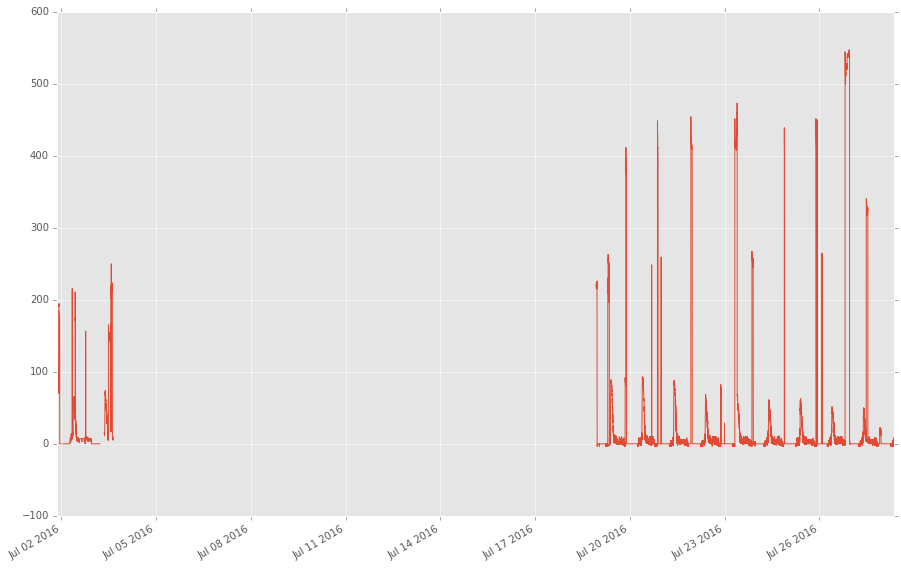

In [7]:
# graph the full raw series
raw_series_writer.result.plot(figsize=(15,10))

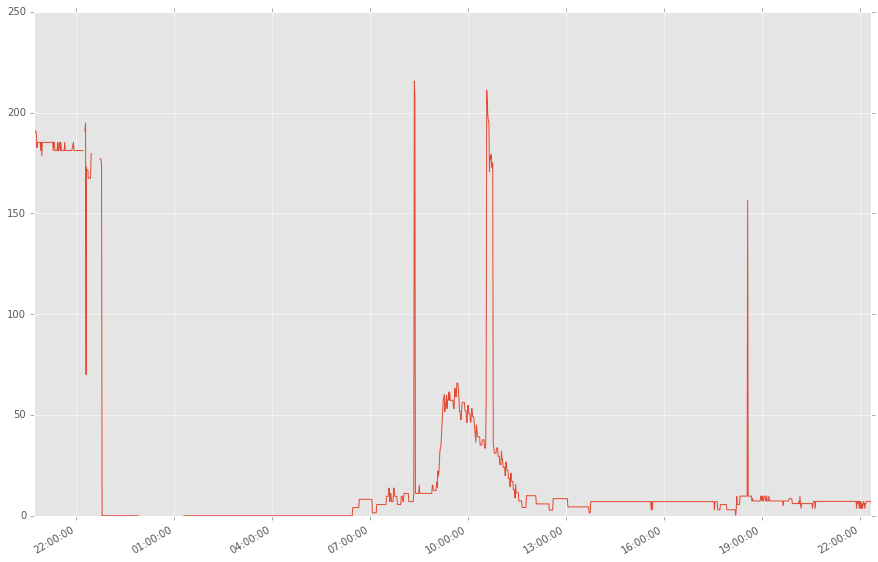

In [8]:
# Graph the last day of the raw data
raw_series_writer.result[:1440].plot(figsize=(15,10))

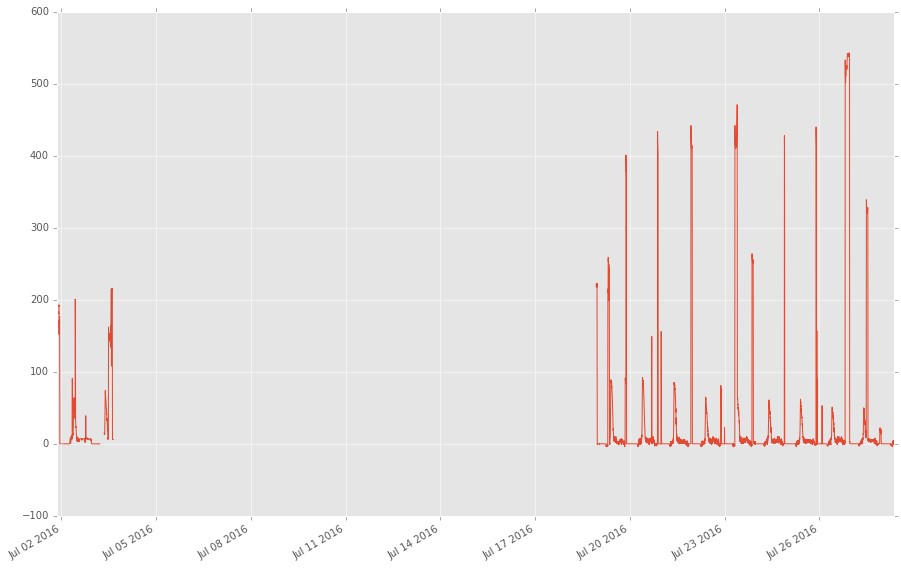

In [9]:
# graph the smoothed series
smoothed_series_writer.result.plot(figsize=(15,10))

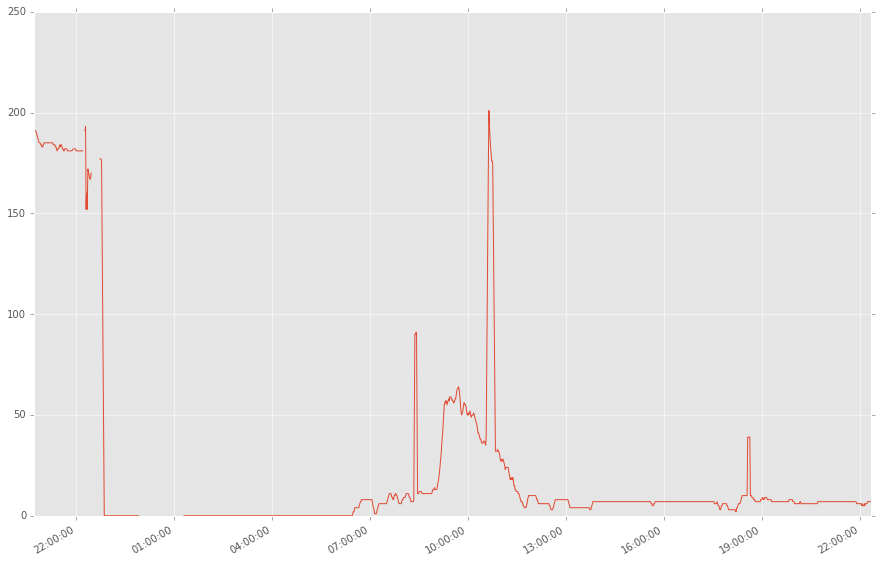

In [10]:
# Graph the last day of the smoothed data
smoothed_series_writer.result[:1440].plot(figsize=(15,10))

replacing index 90 with 0.0
replacing index 106 with 0.0
replacing index 179 with 0.0
replacing index 1859 with 0.0
replacing index 2285 with 0.0
replacing index 7146 with 0.0
[2 2 2 ..., 0 0 0]


(0, 3.5)

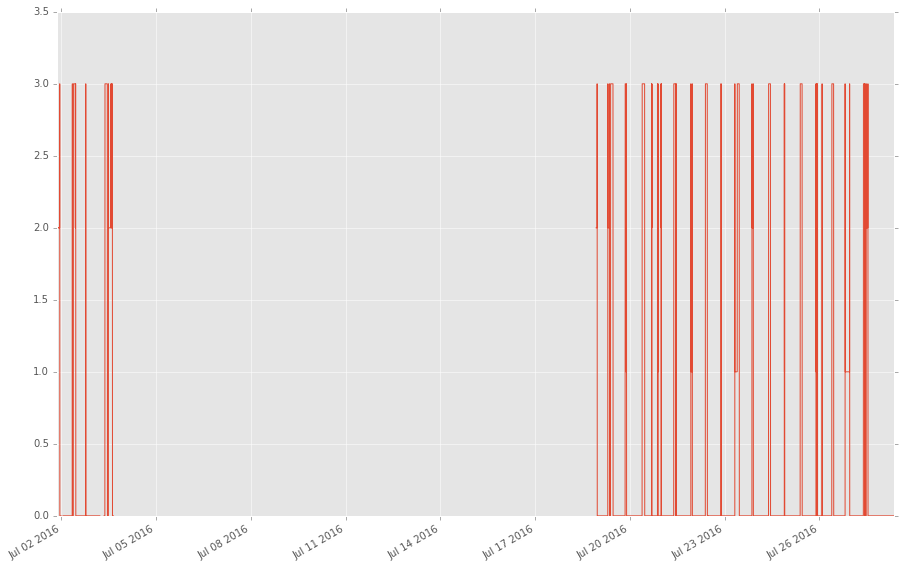

In [11]:
# Now, lets try clustering the data
CLUSTER_LABELS = 4 # how many groups will we create
import numpy as np
from sklearn.cluster import KMeans
npa = np.array(smoothed_series_writer.result).reshape(-1,1)
capture_nan_indexes.replace_nans(npa, 0.0)
kmeans = KMeans(CLUSTER_LABELS)
kmeans.fit(npa)
# print the raw clustered data
print(kmeans.labels_)
from numpy.core.numeric import NaN
labels_with_nans = capture_nan_indexes.new_array_replace_nans(kmeans.labels_, NaN)
labels_against_time = pd.Series(labels_with_nans, index=smoothed_series_writer.index)
labels_against_time.plot(figsize=(15,10))
import pylab
pylab.ylim([0,3.5]) # force the graph top a little higher so that we can see the 3.0 lines

averages = [(2.5461046865489956, 0), (57.099230111206161, 3), (212.66666666666666, 2), (467.7191283292978, 1)]
cluster_mapping = [0, 3, 2, 1]
2016-07-01 20:43:50.824865-07:00    2.0
2016-07-01 20:44:36.398314-07:00    2.0
2016-07-01 20:45:36.343766-07:00    2.0
2016-07-01 20:46:36.464421-07:00    2.0
2016-07-01 20:47:36.385386-07:00    2.0
dtype: float64


(0, 3.5)

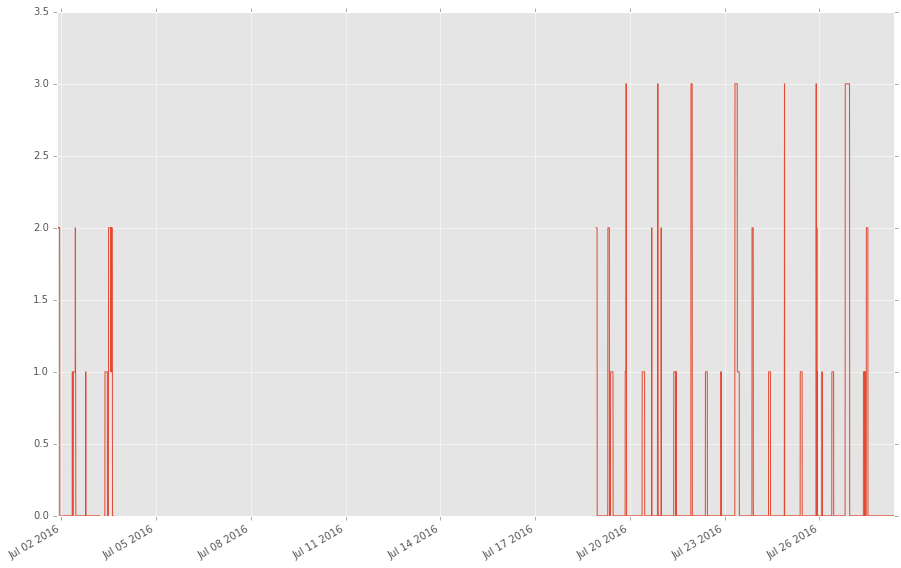

In [12]:
# Unfortunately, the clustered data is creating arbitrary groups. We want the
# integer number to be proportional to the lux value so that the graphs are
# easier to interpret. To do this, we map 0 to the lowest lux level, 3 to
# the highest, etc. In cluster_mapping, the index is the cluster number and
# the value is the one we will graph.
label_totals = [0]*CLUSTER_LABELS
label_counts = [0]*CLUSTER_LABELS
for i in range(len(labels_with_nans)):
    l = labels_with_nans[i]
    if not math.isnan(l):
        lux = smoothed_series_writer.result[i]
        label_totals[l] += lux
        label_counts[l] += 1
averages = [(label_totals[i]/label_counts[i], i) for i in range(CLUSTER_LABELS)]
averages.sort()
print("averages = %s" % averages)
def pivot(array):
    result = [-1]*len(array)
    for i in range(len(array)):
        result[array[i]] = i
    return result
cluster_mapping = pivot([i for (avg, i) in averages])
print("cluster_mapping = %s" % cluster_mapping)
kmeans_lux = [cluster_mapping[l] if not math.isnan(l) else NaN for l in labels_with_nans]
# Now, we can convert it back to a Pandas series by using our original timestamp
# array with the clustered data.
clusters_against_time = pd.Series(kmeans_lux, index=smoothed_series_writer.index)
# print the first few entries
print(clusters_against_time[:5])
clusters_against_time.plot(figsize=(15,10))
import pylab
pylab.ylim([0,3.5]) # force the graph top a little higher so that we can see the 3.0 lines

(0, 3.5)

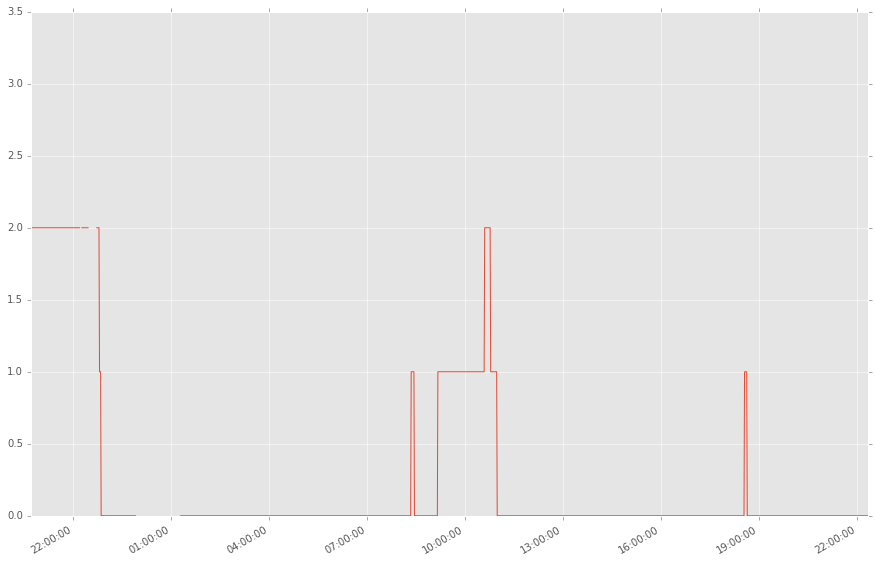

In [13]:
# Lets look at the last day of data to get a closer view
clusters_against_time[:1440].plot(figsize=(15,10))
pylab.ylim([0,3.5]) # force the graph top a little higher so that we can see the 3.0 lines

(0, 1.5)

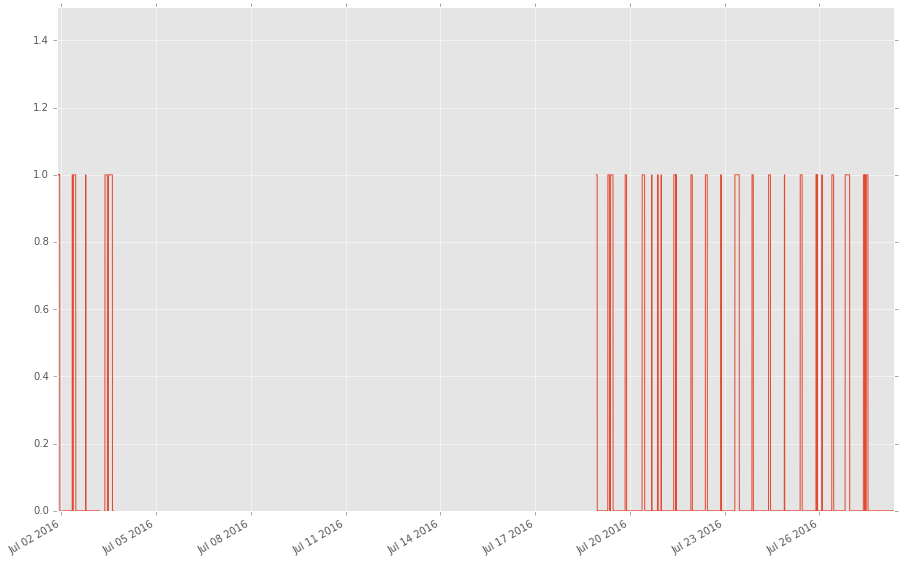

In [14]:
# Now, lets map this to on-off values
def on_off_mapping(v):
    if math.isnan(v):
        return NaN
    elif v>=1:
        return 1
    else:
        return 0

on_off_series = pd.Series([on_off_mapping(l) for l in kmeans_lux], index=smoothed_series_writer.index)
on_off_series.plot(figsize=(15,10))
pylab.ylim([0,1.5])

(0, 1.5)

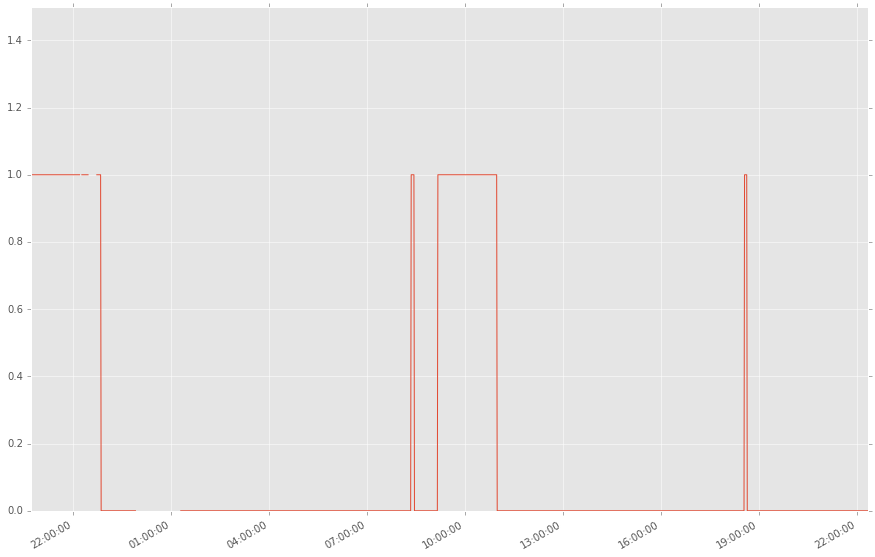

In [15]:
# Graph the last day of the data to get a closer view
on_off_series[:1440].plot(figsize=(15,10))
pylab.ylim([0,1.5])

(0, 4)

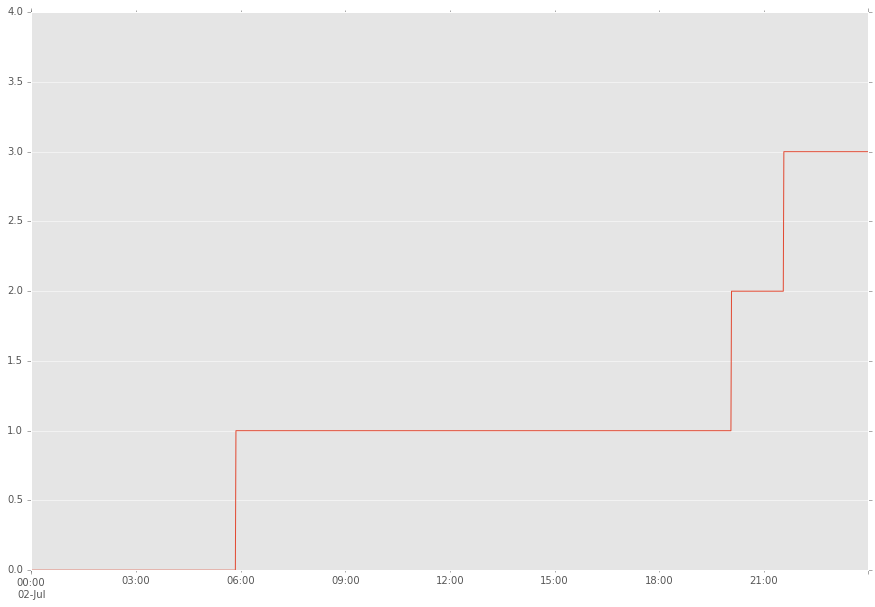

In [16]:
# Import our code that will analyze the data.
import numpy as np
from numpy import float64
import datetime
from lux_analysis import time_of_day_to_zone, dt_to_minutes, NUM_ZONES, get_sunrise_sunset
SUNRISE = 352 # time in minutes since midnight on July 2 (5:52 am)
SUNSET = 1233 # time in minutes since midnight on July 2 (8:33 pm)
(sunrise, sunset) = get_sunrise_sunset(7, 2)
assert SUNRISE==sunrise
assert SUNSET==sunset

# We divide a day into "zones" based on time relative to sunrise/sunset.
# Let's plot our zones for a day
zone_test_index = [datetime.datetime(year=2016, month=7, day=2, hour=h, minute=m)
                   for (h, m) in [(h, m) for h in range(0, 24) for m in range(0, 60)]]
zone_test_data = [time_of_day_to_zone(dt_to_minutes(dt), SUNRISE, SUNSET) for dt in zone_test_index]
zone_test_series = pd.Series(zone_test_data, index=zone_test_index)
zone_test_series.plot(figsize=(15,10))
pylab.ylim([0, NUM_ZONES])

initial state is WAITING
changing to NAN_STATE at 2016-07-01 22:13:39.220200-07:00
changing to WAITING_STATE at 2016-07-01 22:16:48.203777-07:00
changing to NAN_STATE at 2016-07-01 22:29:14.417874-07:00
changing to WAITING_STATE at 2016-07-01 22:44:16.850514-07:00
changing to RECORDING_STATE(0) at 2016-07-01 22:52:16.947294-07:00
changing to NAN_STATE at 2016-07-01 23:56:17.547883-07:00
changing to WAITING_STATE at 2016-07-02 01:18:26.607758-07:00
changing to RECORDING_STATE(1) at 2016-07-02 08:21:31.980507-07:00
ON sequence zone 1, length 6
OFF sequence zone 1, length 43
ON sequence zone 1, length 106
OFF sequence zone 1, length 454
ON sequence zone 1, length 5
changing to NAN_STATE at 2016-07-03 05:20:41.639145-07:00
changing to WAITING_STATE at 2016-07-03 08:31:06.384542-07:00
changing to RECORDING_STATE(1) at 2016-07-03 09:09:06.697680-07:00
ON sequence zone 1, length 112
OFF sequence zone 1, length 49
ON sequence zone 1, length 181
changing to NAN_STATE at 2016-07-03 15:36:11.6326

(array([ 12.,   2.,   4.,   3.,   3.,   5.,   0.,   0.,   0.,   3.]),
 array([   4. ,   23.4,   42.8,   62.2,   81.6,  101. ,  120.4,  139.8,
         159.2,  178.6,  198. ]),
 <a list of 10 Patch objects>)

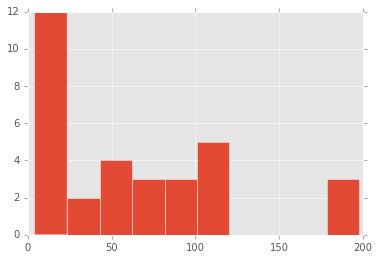

In [17]:
# Load the data into the trainer
from lux_analysis import LightPredictionTrainer

trainer = LightPredictionTrainer(feature_filter=lambda x: (x[0], x[1], x[4]))
trainer.compute(on_off_series, smoothed_series_writer.index)
# look at the distribution of lengths
from itertools import chain
all_on_lengths = list(chain.from_iterable(trainer.on_lengths))
print("all on lengths = %s" % sorted(all_on_lengths))
plt.hist(all_on_lengths)

In [18]:
# Let us look at the number of valid samples we have collected
for zone in range(4):
    print("Zone %s, %d on samples, %d off samples" % (zone, len(trainer.on_lengths[zone]),
                                                      len(trainer.off_lengths[zone])))

Zone 0, 1 on samples, 1 off samples
Zone 1, 20 on samples, 15 off samples
Zone 2, 6 on samples, 3 off samples
Zone 3, 5 on samples, 10 off samples


chose OFF length 425, randomized to 400
chose ON length 5, randomized to 6
chose OFF length 642, randomized to 622
chose ON length 4, randomized to 4
chose OFF length 1, randomized to 1
chose ON length 112, randomized to 115
chose OFF length 642, randomized to 620


(0, 1.5)

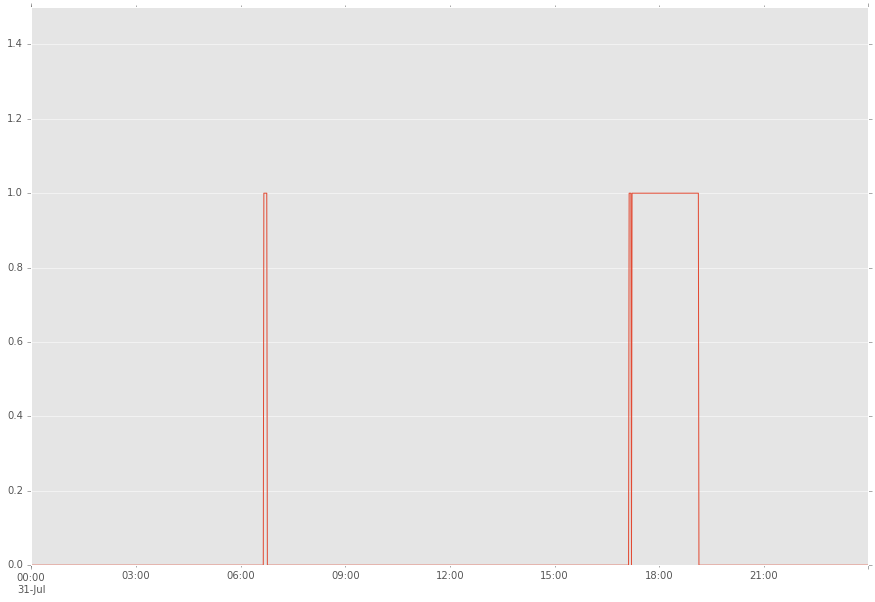

In [19]:

# Lets see what the predicted values would look like for July 31
import datetime
predict_dts_short = [datetime.datetime(year=2016, month=7, day=31, hour=h, minute=m)
                     for (h, m) in [(h, m) for h in range(0, 24) for m in range(0, 60)]]
predict_dts_long = [datetime.datetime(year=2016, month=8, day=d, hour=h, minute=m)
                    for (d, h, m) in [(d, h, m) for d in range(1, 8) for h in range(0, 24) for m in range(0, 60)]]

def predict(predictor_class, trainer, short=True):
    predictor = predictor_class(initial_state=0, trainer=trainer)
    predict_dts = predict_dts_short if short else predict_dts_long
    results = [predictor.predict(dt) for dt in predict_dts]
    return pd.Series(results, index=predict_dts)

from lux_analysis import LightPredictorLengthOnly
predictions = predict(LightPredictorLengthOnly, trainer)
predictions.plot(figsize=(15,10))
pylab.ylim([0, 1.5])

chose OFF length 425, randomized to 372
chose ON length 102, randomized to 113
chose OFF length 54, randomized to 48
chose ON length 195, randomized to 212
chose OFF length 247, randomized to 323
chose ON length 5, randomized to 6
chose OFF length 454, randomized to 439


(0, 1.5)

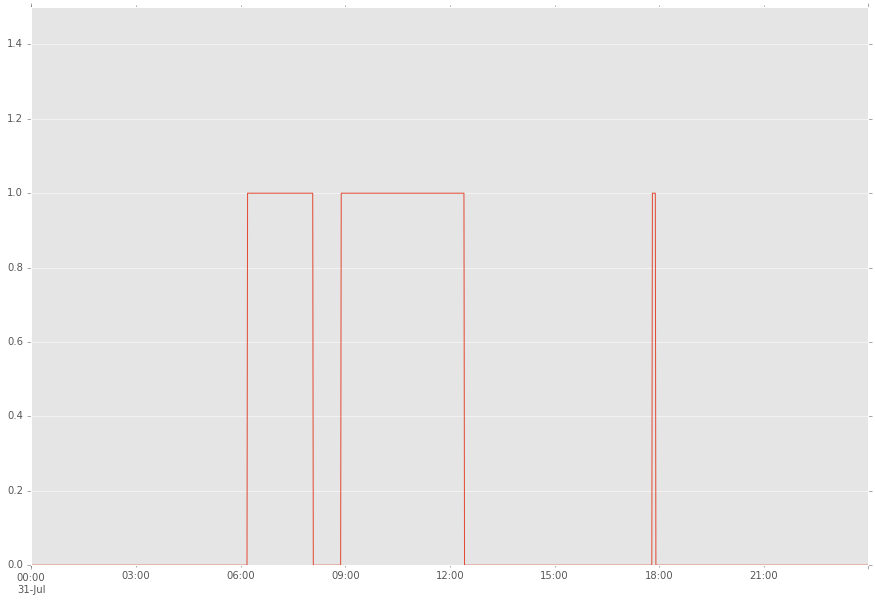

In [20]:
from lux_analysis import LightPredictorLengthOnly
predictions = predict(LightPredictorLengthOnly, trainer)
predictions.plot(figsize=(15,10))
pylab.ylim([0, 1.5])

chose OFF length 425, randomized to 439
chose ON length 181, randomized to 186
chose OFF length 604, randomized to 523
chose ON length 62, randomized to 57
chose OFF length 130, randomized to 126
chose ON length 62, randomized to 68
chose OFF length 209, randomized to 180
chose ON length 5, randomized to 6
chose OFF length 425, randomized to 409
chose ON length 4, randomized to 4
chose OFF length 6, randomized to 6
chose ON length 66, randomized to 69
chose OFF length 1, randomized to 1
chose ON length 5, randomized to 4
chose OFF length 50, randomized to 44
chose ON length 62, randomized to 58
chose OFF length 54, randomized to 46
chose ON length 112, randomized to 121
chose OFF length 43, randomized to 40
chose ON length 73, randomized to 83
chose OFF length 6, randomized to 6
chose ON length 86, randomized to 96
chose OFF length 532, randomized to 550
chose ON length 5, randomized to 5
chose OFF length 425, randomized to 380
chose ON length 112, randomized to 124
chose OFF length 54

(0, 1.5)

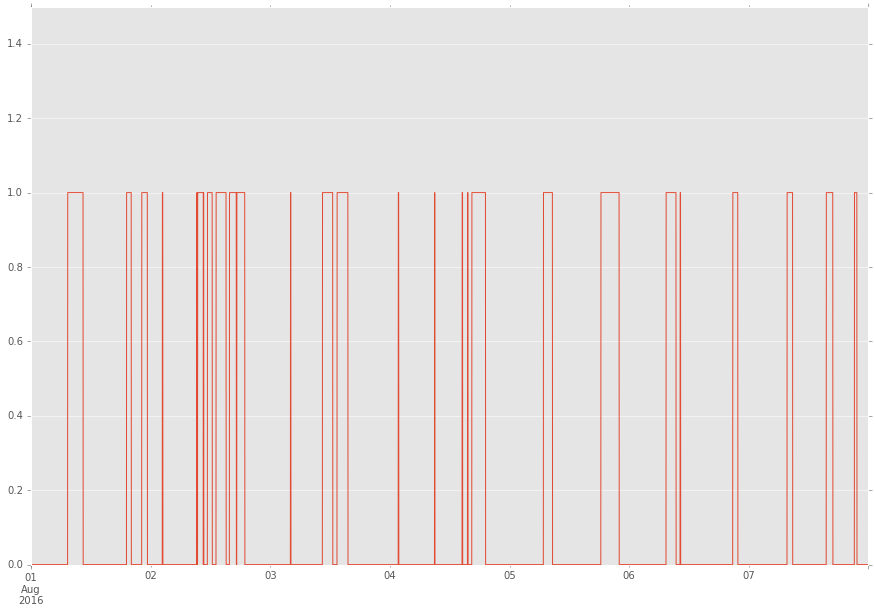

In [21]:
# Run again
predictions = predict(LightPredictorLengthOnly, trainer, short=False)
predictions.plot(figsize=(15,10))
pylab.ylim([0, 1.5])

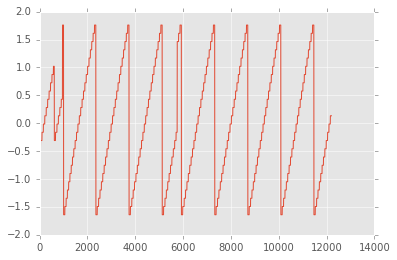

In [22]:
# Look at the feature data
# First, the minutes in the day
plt.plot([f[0] for f in trainer.scaled_features])

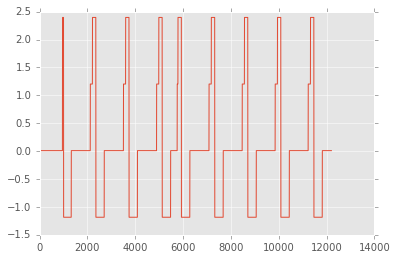

In [23]:
# Second, the zone
plt.plot([f[1] for f in trainer.scaled_features])

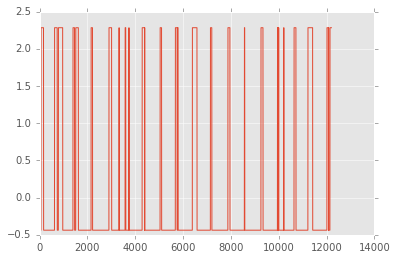

In [24]:
## Third, the length if zero
# The value back N steps
plt.plot([f[2] for f in trainer.scaled_features])

In [25]:
# Fourth, the length if one
#plt.plot([f[3] for f in trainer.scaled_features])

In [26]:
# Fifth, the value back N steps
#plt.plot([f[4] for f in trainer.scaled_features])

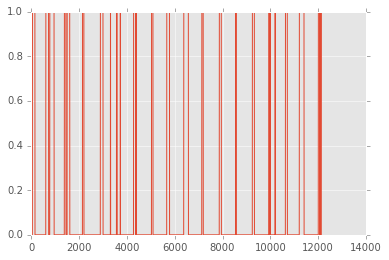

In [27]:
# The training values
plt.plot(trainer.training_targets)

In [28]:
# lets print all the features as a check
for i in range(len(trainer.training_features)):
    print("%s => %s" % (trainer.training_features[i], trainer.training_targets[i]))

(8, 1, 0) => 1
(8, 1, 0) => 1
(8, 1, 0) => 1
(8, 1, 0) => 1
(8, 1, 0) => 1
(8, 1, 0) => 1
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 1) => 0
(8, 1, 1) => 0
(8, 1, 1) => 0
(8, 1, 1) => 0
(8, 1, 1) => 0
(8, 1, 1) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(8, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 0
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 0) => 1
(9, 1, 1) => 1
(9, 1, 1) => 1
(9, 1, 1) => 1
(9, 1, 1) => 1
(9, 1, 1) => 1
(9, 1, 1) => 1
(9, 1, 1) => 1
(9, 1, 1) 

using 12204 features


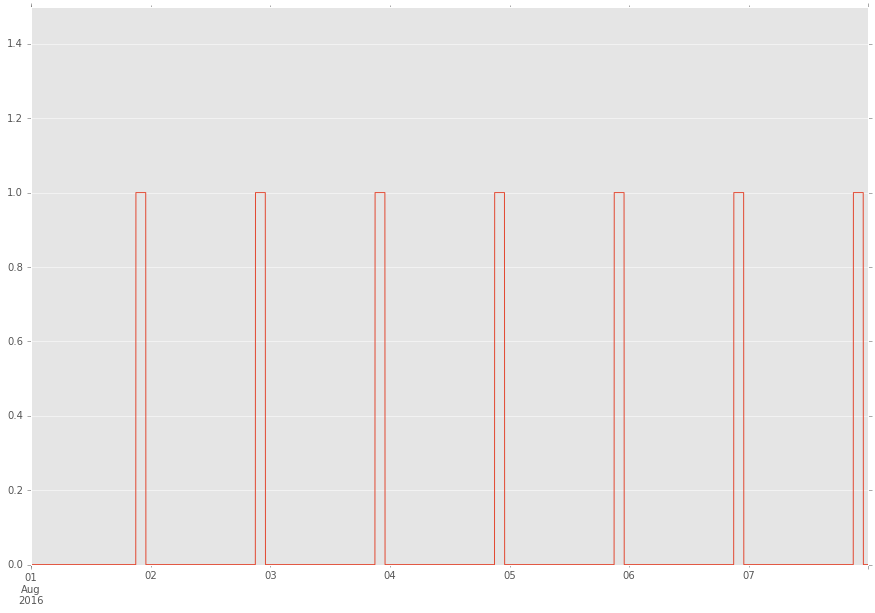

In [29]:
def scikit_predict(classifier, short=True, scaled=True):
    print("using %d features" % len(trainer.scaled_features))
    classifier.fit(trainer.scaled_features if scaled else trainer.training_features,
                   trainer.training_targets)
    predict_dts = predict_dts_short if short else predict_dts_long
    state = 0
    length = 1
    predictions = []
    sample_queue = []
    for dt in predict_dts:
        features = trainer.features_for_prediction(state, dt, length, sample_queue, scaled=scaled)
        try:
            new_predictions = classifier.predict(features)
        except:
            print("Got exception from classifier.predict(%s)" % features.__repr__())
            raise
        new_state = new_predictions[0]
        sample_queue.append(new_state)
        if new_state==state:
            length += 1
        else:
            length = 1
        predictions.append(new_state)
        state = new_state
    return pd.Series(predictions, index=predict_dts)
    
def plot(predictions):
    predictions.plot(figsize=(15,10))
    pylab.ylim([0, 1.5])
    
# First, we start with a K-nearest-neighbors classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knnpredictions = scikit_predict(knn, short=False)
plot(knnpredictions)

using 12204 features


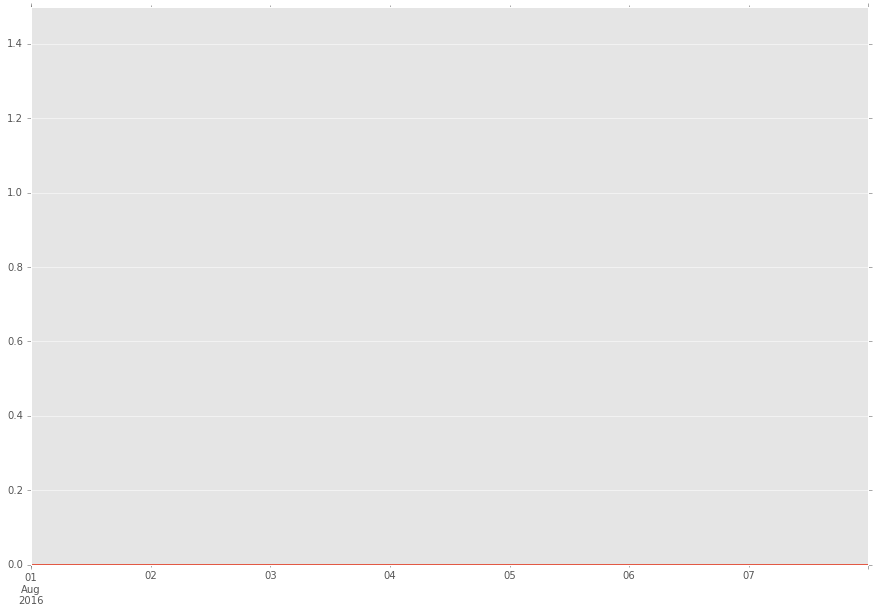

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0)
lrpredictions = scikit_predict(lr, short=False)
plot(lrpredictions)

using 12204 features


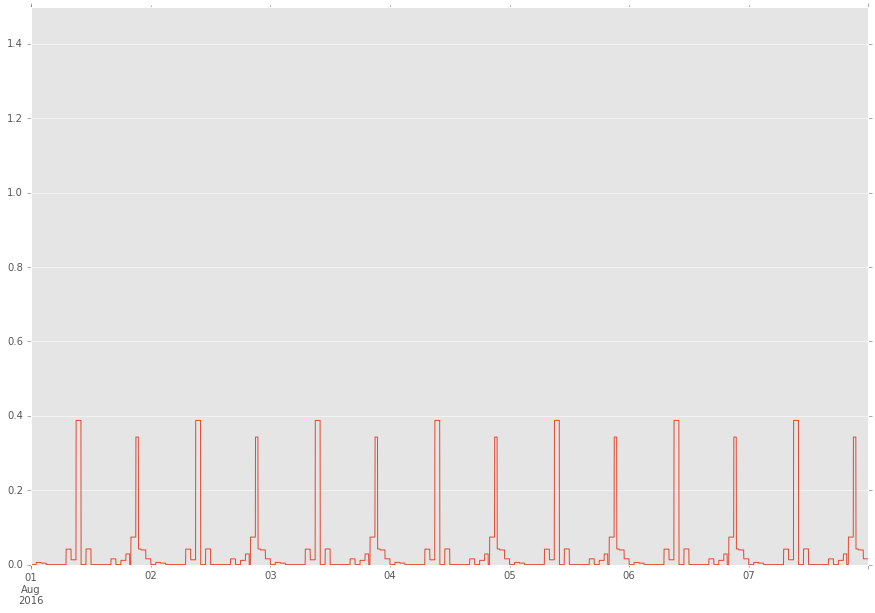

In [31]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtrpredictions = scikit_predict(dtr, short=False)
plot(dtrpredictions)

using 12204 features


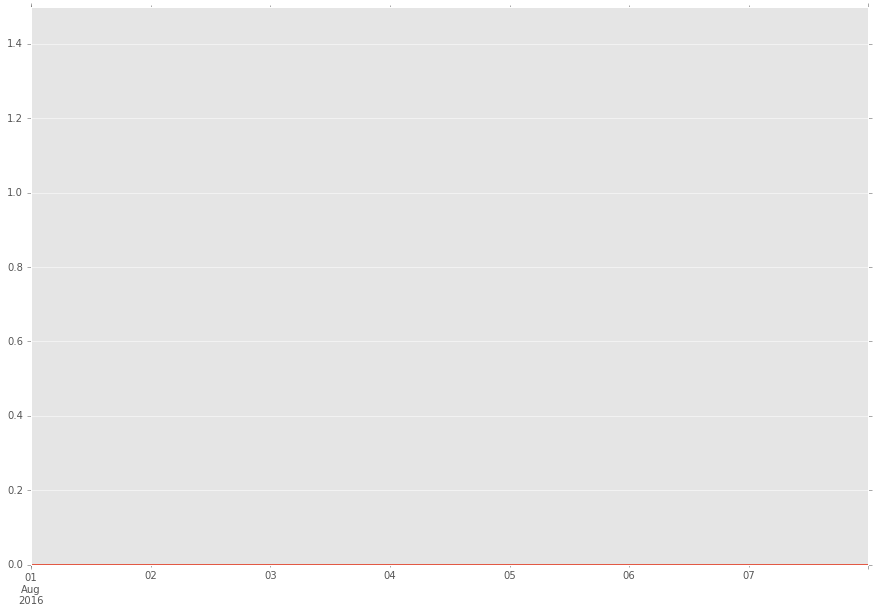

In [32]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtcpredictions = scikit_predict(dtc, short=False, scaled=False)
plot(dtcpredictions)

using 12204 features
features.shape: (12204, 3)
feature importances: array([ 0.07033706,  0.01480185,  0.91486109])
Classes: array([0, 1]), index for 0 is 0


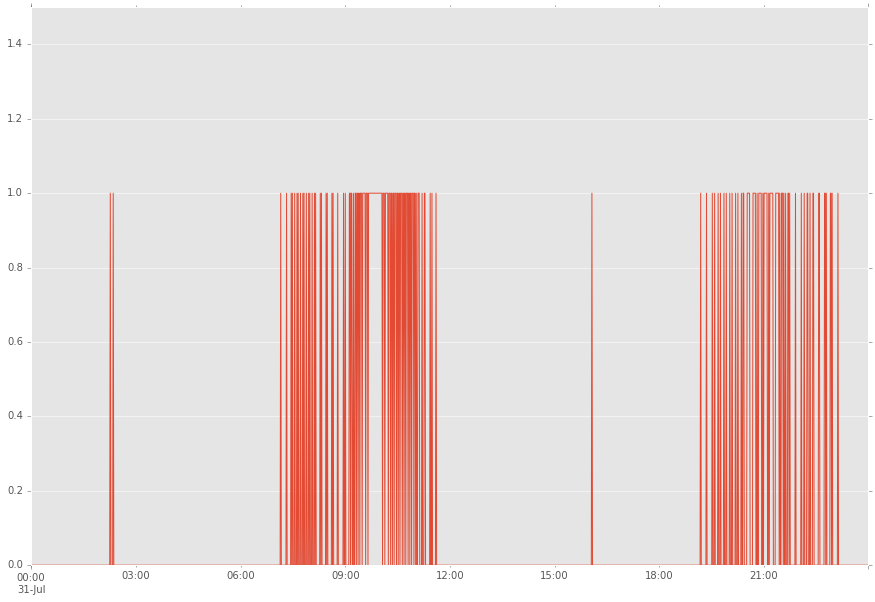

In [33]:
import random
def scikit_predict_proba(classifier, short=True, initial_state=0, scaled=False):
    print("using %d features" % len(trainer.training_features))
    features = np.array(trainer.scaled_features if scaled else trainer.training_features)
    print("features.shape: %s" % repr(features.shape))
    num_training_features = features.shape[1]
    classifier.fit(features,
                   np.array(trainer.training_targets))
    print("feature importances: %s" % repr(classifier.feature_importances_))
    predict_dts = predict_dts_short if short else predict_dts_long
    assert len(classifier.classes_)==2
    zero_class_idx = 0 if int(classifier.classes_[0])==0 else 1
    print("Classes: %s, index for 0 is %s" % (classifier.classes_.__repr__(), zero_class_idx))
    state = initial_state
    length = 1
    predictions = []
    sample_queue = []
    for dt in predict_dts:
        features = np.array(trainer.features_for_prediction(state, dt, length, sample_queue, scaled=scaled))
        assert features.shape[1]==num_training_features
        try:
            probabilities = classifier.predict_proba(features)

        except:
            print("Got exception from classifier.predict_proba(%s)" % features.__repr__())
            raise
        prob_zero = probabilities[0][zero_class_idx]
        p = random.random()
        if p <= prob_zero:
            new_state = 0
        else:
            new_state = 1
        #print("feature: %s probabilities: %s, prob_zero: %s, p: %s, new_state: %s" %
        #      (features[0], probabilities[0], prob_zero, round(p, 4), new_state))
        sample_queue.append(new_state)
        if new_state==state:
            length += 1
        else:
            length = 1
        predictions.append(new_state)
        state = new_state
    return pd.Series(predictions, index=predict_dts)

dtc = DecisionTreeClassifier() # don't use balanced - it will not catch the big gaps during the day
dtcpredictions = scikit_predict_proba(dtc, short=True, scaled=False)
#from sklearn.externals.six import StringIO
#from sklearn.tree import export_graphviz
#with open("tree.dot", 'w') as f:
#    export_graphviz(dt, out_file=f)
plot(dtcpredictions)

3140 samples for zone 0


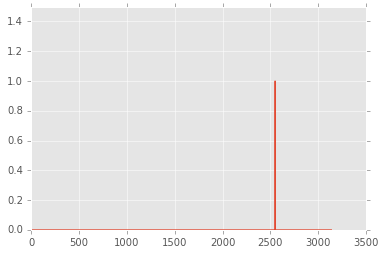

In [34]:
# show the observations for the overnight zone (0)
def plotzone(z):
    print("%d samples for zone %d" % (len(trainer.obs_by_zone[z]), z))
    plt.plot(trainer.obs_by_zone[z])
    pylab.ylim([0, 1.5])
plotzone(0)

7195 samples for zone 1


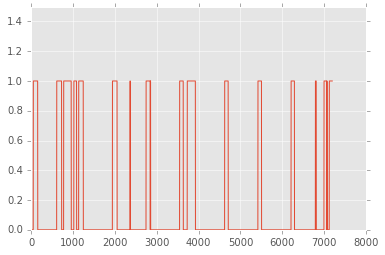

In [35]:
# show the observations for the daytime zone (1)
plotzone(1)

683 samples for zone 2


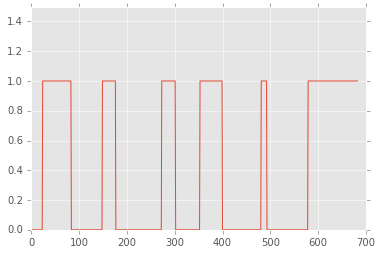

In [36]:
# show the observations for the evening zone (2)
plotzone(2)

1186 samples for zone 3


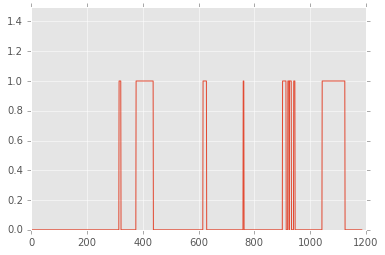

In [37]:
# show the observations for the late evening zone (3)
plotzone(3)

5 states for zone 0
5 states for zone 1
5 states for zone 2
5 states for zone 3
add 372 events for zone 0 on day 7/31
add 815 events for zone 1 on day 7/31
add 104 events for zone 2 on day 7/31
add 149 events for zone 3


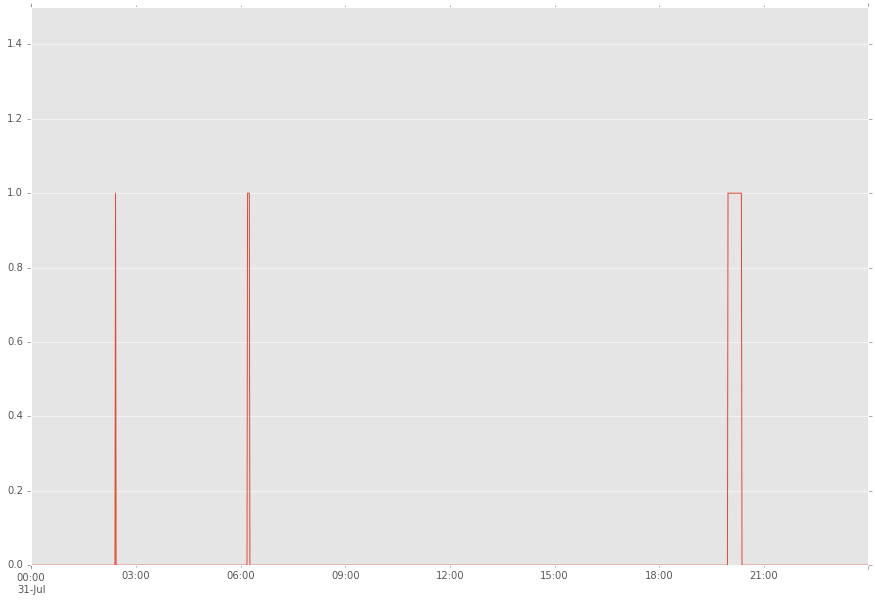

In [38]:
from hmmlearn.hmm import MultinomialHMM as MHMM
# train hmms by zone
hmm_by_zone = []
for z in range(NUM_ZONES):
    num_states = 5 #max(3, int(1+len(trainer.on_lengths[z])/2))
    print("%d states for zone %d" % (num_states, z))            
    hmm = MHMM(n_components=num_states)
    data = np.array(trainer.obs_by_zone[z]).reshape(-1, 1)
    hmm.fit(data)
    hmm_by_zone.append(hmm)

def predict_hmm_by_zone(dt_series):
    predictions = []
    last_zone = None
    last_cnt = None
    for dt in dt_series:
        (sunrise, sunset) = get_sunrise_sunset(dt.month, dt.day)
        zone = time_of_day_to_zone(dt_to_minutes(dt), sunrise, sunset)
        if zone != last_zone:
            if last_cnt is not None:
                print("add %d events for zone %d on day %d/%d" % (last_cnt, last_zone, dt.month, dt.day))
                (samples, states) = hmm_by_zone[last_zone].sample(last_cnt)
                predictions.extend([x[0] for x in samples])
            last_cnt = 1
        else:
            last_cnt += 1
        last_zone = zone
    if last_zone is not None:
        print("add %d events for zone %d" % (last_cnt, last_zone))
        (samples, states) = hmm_by_zone[last_zone].sample(last_cnt)
        predictions.extend([x[0] for x in samples])
    assert len(predictions)==len(dt_series)
    return pd.Series(predictions, index=dt_series)

short_predictions = predict_hmm_by_zone(predict_dts_short)
plot(short_predictions)

add 373 events for zone 0 on day 8/1
add 813 events for zone 1 on day 8/1
add 105 events for zone 2 on day 8/1
add 149 events for zone 3 on day 8/2
add 374 events for zone 0 on day 8/2
add 811 events for zone 1 on day 8/2
add 106 events for zone 2 on day 8/2
add 149 events for zone 3 on day 8/3
add 375 events for zone 0 on day 8/3
add 809 events for zone 1 on day 8/3
add 107 events for zone 2 on day 8/3
add 149 events for zone 3 on day 8/4
add 376 events for zone 0 on day 8/4
add 807 events for zone 1 on day 8/4
add 108 events for zone 2 on day 8/4
add 149 events for zone 3 on day 8/5
add 376 events for zone 0 on day 8/5
add 806 events for zone 1 on day 8/5
add 109 events for zone 2 on day 8/5
add 149 events for zone 3 on day 8/6
add 377 events for zone 0 on day 8/6
add 804 events for zone 1 on day 8/6
add 110 events for zone 2 on day 8/6
add 149 events for zone 3 on day 8/7
add 378 events for zone 0 on day 8/7
add 802 events for zone 1 on day 8/7
add 111 events for zone 2 on day 8/7
a

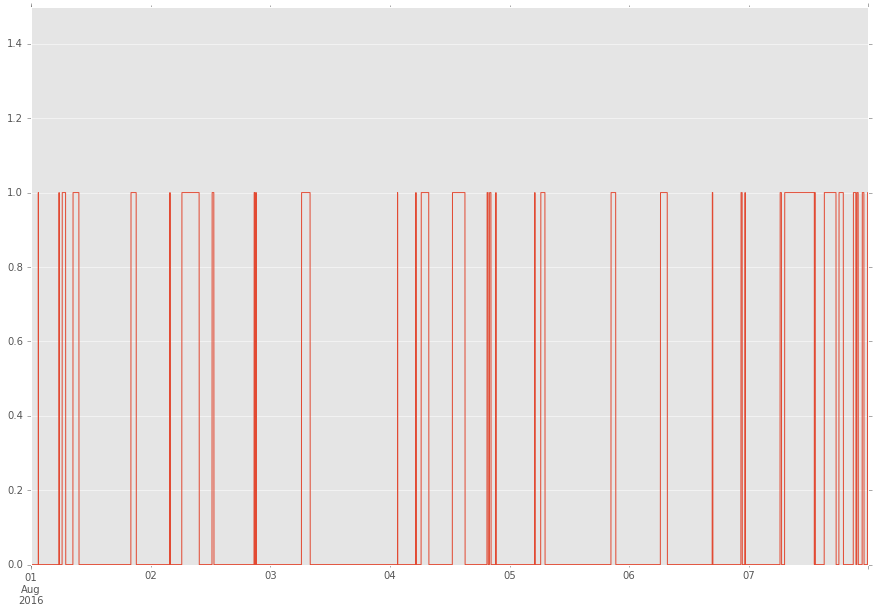

In [39]:
long_predictions = predict_hmm_by_zone(predict_dts_long)
plot(long_predictions)

In [40]:
# save the trained HMM to a file
from sklearn.externals import joblib
import os.path
if not os.path.exists('saved_hmms'):
    os.mkdir('saved_hmms')
    print("created saved_hmms direectory")
for zone in range(NUM_ZONES):
    fname = 'saved_hmms/hmm-%s-zone-%d.pkl' % (ROOM, zone)
    joblib.dump(hmm_by_zone[zone], fname)
    print("save hmm to %s" % fname)


created saved_hmms direectory
save hmm to saved_hmms/hmm-front-room-zone-0.pkl
save hmm to saved_hmms/hmm-front-room-zone-1.pkl
save hmm to saved_hmms/hmm-front-room-zone-2.pkl
save hmm to saved_hmms/hmm-front-room-zone-3.pkl
